<a href="https://colab.research.google.com/github/InMyDream21/Deep-Learning/blob/main/Tensorflow/zerotomastery/computer_vision/Transfer_learning_in_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow part 1: Feature extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on simmilar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we using a gpu?
!nvidia-smi

Mon Jan 10 06:21:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-01-11 04:31:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2022-01-11 04:31:25 (165 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os

# Walk through 10 percent data directory
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak

## Create data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (fucntionized becuase we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir,)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

## Creating model using TensorFlow Hub

In the past weve used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub

We can access pretrained models on: https://tfhub.dev/

In [ ]:
# Lets compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a url
def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, should be equal to number of targer classes, default 10.

    Returns:
      An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False, # Freeze the already learned patterns
                                           name = "feature_extraction_layers",
                                           input_shape = IMAGE_SHAPE + (3,)) 
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation = "softmax", name = "output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layers (  (None, 2048)             23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Lets fit our resnet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnetv250")])

Saving Tensorboard log files to: tensorflow_hub/resnetv250/20220111-044002
Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 1.8300 - accuracy: 0.4080 - val_loss: 1.1381 - val_accuracy: 0.6392
Epoch 2/5
24/24 [==============================] - 22s 934ms/step - loss: 0.8817 - accuracy: 0.7440 - val_loss: 0.8165 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - 22s 928ms/step - loss: 0.6111 - accuracy: 0.8267 - val_loss: 0.7156 - val_accuracy: 0.7704
Epoch 4/5
24/24 [==============================] - 21s 922ms/step - loss: 0.4657 - accuracy: 0.8733 - val_loss: 0.6828 - val_accuracy: 0.7804
Epoch 5/5
24/24 [==============================] - 22s 925ms/step - loss: 0.3794 - accuracy: 0.9120 - val_loss: 0.6760 - val_accuracy: 0.7776


In [ ]:
# Create a function to plot our loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    History: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "training loss")
  plt.plot(epochs, val_loss, label = "val loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training accuracy")
  plt.plot(epochs, val_accuracy, label = "val accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

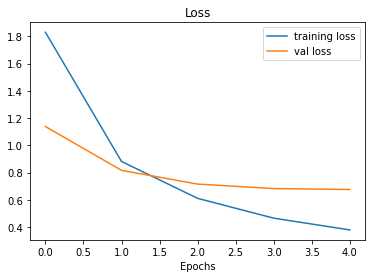

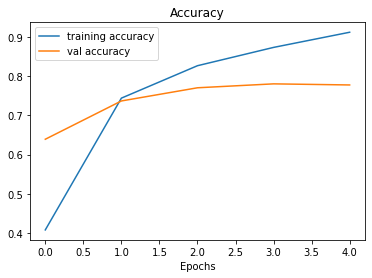

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(efficientnet_url,
                                  train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback("tensorflow_hub",
                                                                                       "efficientnetb0")])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20220111-044255
Epoch 1/5
24/24 [==============================] - 32s 866ms/step - loss: 1.8801 - accuracy: 0.4280 - val_loss: 1.3211 - val_accuracy: 0.7148
Epoch 2/5
24/24 [==============================] - 18s 778ms/step - loss: 1.0900 - accuracy: 0.7520 - val_loss: 0.8804 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 19s 799ms/step - loss: 0.7689 - accuracy: 0.8373 - val_loss: 0.7049 - val_accuracy: 0.8504
Epoch 4/5
24/24 [==============================] - 18s 775ms/step - loss: 0.6182 - accuracy: 0.8640 - val_loss: 0.6124 - val_accuracy: 0.8636
Epoch 5/5
24/24 [==============================] - 18s 781ms/step - loss: 0.5200 - accuracy: 0.8840 - val_loss: 0.5559 - val_accuracy: 0.8684


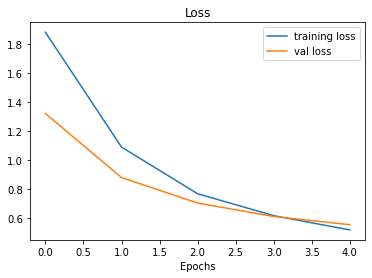

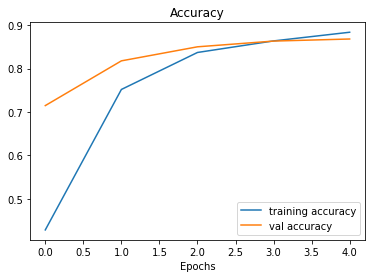

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layers (  (None, 1280)             4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layers (  (None, 2048)             23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# how many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature Extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - Use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> **Note:** When you upload things to TensorBoard.dev your experiments are publi. So if you're running private experiments (things you dont want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2 vs. Mobilenetv2-100-224" \
  --description "Comparing three different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=8n2t3QvAiqnNtpxetc1Y4wCG1hhz6p&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/BIM30wDKRRC4L7MxJHyOzA/
and
https://tensorboard.dev/experiment/FD1QZNkRRz6veCWgoG8IDQ/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/BIM30wDKRRC4L7MxJHyOzA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   BIM30wDKRRC4L7MxJHyOzA
	Created              2022-01-10 08:05:09 (4 minutes ago)
	Updated              2022-01-10 08:05:12 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5797954
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id BIM30wDKRRC4L7MxJHyOzA
# Confirm the deletion by re-checking what experiments you have left

## Trying the mobilenet_v2_100_224 Architecture

The link is: https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5

In [ ]:
# Setup the url
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [ ]:
# Create the model
mobilenet_model = create_model(mobilenet_url,
                               train_data_10_percent.num_classes)

# Compile the model
mobilenet_model.compile(loss = "categorical_crossentropy",
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

In [ ]:
# Fit the model
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs = 5,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = len(test_data),
                                        callbacks = [create_tensorboard_callback("tensorflow_hub",
                                                                                  "mobilenetv2100")])

Saving Tensorboard log files to: tensorflow_hub/mobilenetv2100/20220111-043707
Epoch 1/5
24/24 [==============================] - 32s 830ms/step - loss: 2.0586 - accuracy: 0.2960 - val_loss: 1.3399 - val_accuracy: 0.6080
Epoch 2/5
24/24 [==============================] - 18s 764ms/step - loss: 1.0942 - accuracy: 0.6787 - val_loss: 0.9207 - val_accuracy: 0.7216
Epoch 3/5
24/24 [==============================] - 18s 759ms/step - loss: 0.7658 - accuracy: 0.7827 - val_loss: 0.7727 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 18s 783ms/step - loss: 0.6006 - accuracy: 0.8280 - val_loss: 0.6984 - val_accuracy: 0.7864
Epoch 5/5
24/24 [==============================] - 18s 761ms/step - loss: 0.5006 - accuracy: 0.8680 - val_loss: 0.6566 - val_accuracy: 0.8008
